# **Project name: Endoscopic Capsule**

# **Project configuration**

## Folders and files


In [52]:
## Project folder
collab_path = '/content/'
project_path = collab_path

## Imagery folders
imagery_path = ''
raw_imagery_path = '/raw/'

## Drive folder
drive_path = '/content/drive'
drive_project_path = '/MyDrive/ML_Capstone'
drive_test_path = '/test/'

## Project dataset
file_id = "1_h7juQZBxbwx-JqVBbwaWIEhaNvTY-PW"
file_name = "LMR_Capstone_single.zip"
classes_file = "classes_paper.csv"
#image_size = 336
image_size = 112
image_bands = 3
training_file = 'split_0.csv'
validation_file = 'split_1.csv'

## Training
num_epochs  = 25
retrain = False
#save_model = True
model_name = "model_cnn"
history_name = "history"

## Loading Libraries

In [53]:
!pip install tensorflow-addons

import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
import cv2

import sklearn.metrics as mtc
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa

import keras.models
import keras.layers
from keras.models import Sequential
from keras.layers import Activation, Dense

%matplotlib inline
plt.style.use('ggplot')

## Environtment information

In [54]:
print(tf.version.VERSION)

2.8.0


In [55]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [57]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setting-up the environtment (Google-Drive)

In [58]:
from google.colab import drive
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
if not os.path.exists(drive_path+drive_project_path):
  os.makedirs(drive_path+drive_project_path)
if not os.path.exists(drive_path+drive_project_path+drive_test_path):
  os.makedirs(drive_path+drive_project_path+drive_test_path)

In [60]:
if not os.path.exists(file_name):
  !pip install gdown
  !gdown --id $file_id

In [61]:
#unzip the data
dir = project_path+imagery_path
!unzip -q -n $file_name -d $dir
dir

'/content/'

# **Loading and preparing training / validation data**

In [62]:
training_dir = project_path + imagery_path + os.path.splitext(training_file)[0] + "/"
if not os.path.exists(training_dir):
  os.makedirs(training_dir)

validation_dir = project_path + imagery_path + os.path.splitext(validation_file)[0] + "/"
if not os.path.exists(validation_dir):
  os.makedirs(validation_dir)

In [63]:
file = project_path + imagery_path + training_file
labels = pd.read_csv(file)   # loading the labels
dir = project_path+imagery_path+'raw/'

for filename, label in zip(labels['filename'], labels['label']):
  if not os.path.exists(training_dir + '/' + label):
    os.makedirs(training_dir + '/' + label)
  shutil.copy(dir + filename, training_dir + '/' + label)
  
  gs_img = cv2.imread(training_dir + '/' + label + '/' + filename)
  gs_res_img = cv2.resize(gs_img, (image_size, image_size))
  cv2.imwrite(training_dir + '/' + label + '/' + filename, gs_res_img)

In [64]:
file = project_path + imagery_path + validation_file
labels = pd.read_csv(file)   # loading the labels
dir = project_path+imagery_path+'raw/'

for filename, label in zip(labels['filename'], labels['label']):
  if not os.path.exists(validation_dir + '/' + label):
    os.makedirs(validation_dir + '/' + label)
  shutil.copy(dir + filename, validation_dir + '/' + label)

  gs_img = cv2.imread(validation_dir + '/' + label + '/' + filename)
  gs_res_img = cv2.resize(gs_img, (image_size, image_size))
  cv2.imwrite(validation_dir + '/' + label + '/' + filename, gs_res_img)

In [65]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [66]:
train_generator = train_datagen.flow_from_directory(training_dir,
                                                    class_mode='categorical',
                                                    target_size=(image_size, image_size))

Found 23061 images belonging to 11 classes.


In [67]:
# No need to augment validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

In [68]:
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              class_mode='categorical',
                                                              target_size=(image_size, image_size))

Found 24100 images belonging to 11 classes.


# **Training**

## DenseNet169


In [69]:
from tensorflow.keras.applications.densenet import DenseNet169

model = DenseNet169(input_shape=(image_size,image_size,image_bands),include_top = False, weights= 'imagenet')

for layer in model.layers:  
    layer.trainable=False

x = model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.4)(x)      
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)                  
x = keras.layers.Dense(11, activation='softmax')(x) 
model = keras.Model(model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 118, 118, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 56, 56, 64)   9408        ['zero_padding2d_4[0][0]']       
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.493754 to fit



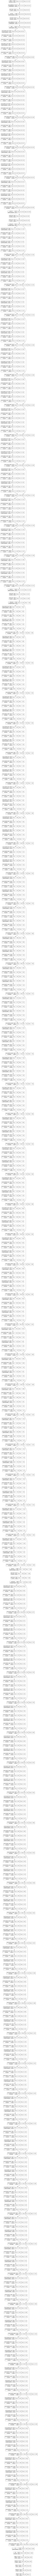

In [70]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [71]:
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics=[tf.keras.metrics.Accuracy(), tfa.metrics.F1Score(num_classes=11, average="micro"), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.MatthewsCorrelationCoefficient(num_classes=11)])


In [72]:
model_filepath = drive_path + drive_project_path + drive_test_path +  model_name

In [73]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_filepath,
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)

In [74]:
if retrain:
  model.load_weights(model_filepath)

## Fiting the model

In [75]:
train_history = model.fit(train_generator, 
                          epochs=num_epochs,
                          verbose=1,
                          validation_data=validation_generator)
#                          batch_size=1024,
#                          validation_data=(x_val, y_val),
#                          class_weight=dic_weights,
#                          callbacks=[cp_callback])

Epoch 1/25
721/721 [==============================] - 81s 97ms/step - loss: 0.6008 - accuracy: 2.1682e-04 - f1_score: 0.8498 - precision_1: 0.8821 - recall_1: 0.8182 - MatthewsCorrelationCoefficient: 0.6902 - val_loss: 1.2195 - val_accuracy: 3.3949e-05 - val_f1_score: 0.7521 - val_precision_1: 0.7830 - val_recall_1: 0.7196 - val_MatthewsCorrelationCoefficient: 0.3076
Epoch 2/25
721/721 [==============================] - 68s 94ms/step - loss: 0.2870 - accuracy: 1.7345e-04 - f1_score: 0.9100 - precision_1: 0.9265 - recall_1: 0.8949 - MatthewsCorrelationCoefficient: 0.8180 - val_loss: 1.3756 - val_accuracy: 3.4327e-04 - val_f1_score: 0.7547 - val_precision_1: 0.7739 - val_recall_1: 0.7364 - val_MatthewsCorrelationCoefficient: 0.2964
Epoch 3/25
721/721 [==============================] - 67s 92ms/step - loss: 0.2274 - accuracy: 7.8054e-04 - f1_score: 0.9268 - precision_1: 0.9416 - recall_1: 0.9153 - MatthewsCorrelationCoefficient: 0.8527 - val_loss: 1.2805 - val_accuracy: 7.9215e-05 - val_f

In [76]:
model_filepath = drive_path + drive_project_path + drive_test_path +  model_name
model_filepath

'/content/drive/MyDrive/ML_Capstone/test/model_cnn'

In [77]:
train_history.history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'precision_1', 'recall_1', 'MatthewsCorrelationCoefficient', 'val_loss', 'val_accuracy', 'val_f1_score', 'val_precision_1', 'val_recall_1', 'val_MatthewsCorrelationCoefficient'])

## Plot history

In [78]:
ac = train_history.history['accuracy']
v_ac = train_history.history['val_accuracy']   
lo = train_history.history['loss']
v_lo = train_history.history['val_loss']
f = train_history.history['f1_score']
v_f = train_history.history['val_f1_score']
epochs = train_history.epoch

Text(0, 0.5, 'Accuracy')

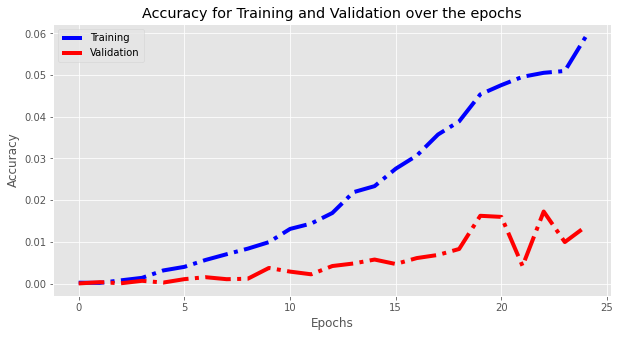

In [79]:
plt.figure(figsize=(10,5),frameon=False)
plt.plot(epochs,ac,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_ac,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Accuracy for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

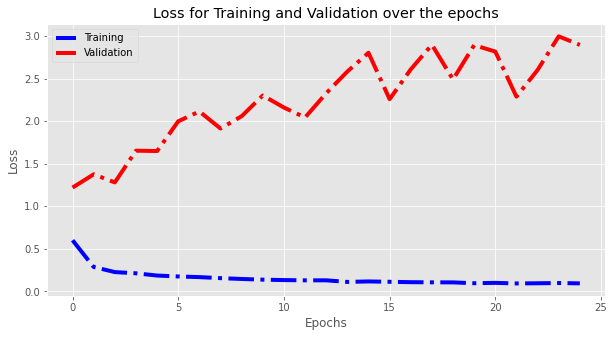

In [80]:
plt.figure(figsize=(10,5))
plt.plot(epochs,lo,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_lo,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Loss for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'f1')

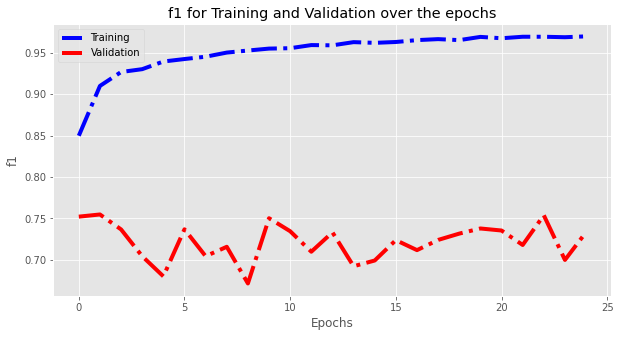

In [81]:
plt.figure(figsize=(10,5))
plt.plot(epochs,f,c='b',ls='-.',lw='4',label='Training')
plt.plot(epochs,v_f,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('f1 for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('f1')

## Evaluating the model

In [82]:
loss, accuracy, f1_score, precision, recall, MCC = model.evaluate(validation_generator, verbose=0)

In [83]:
print ("loss =",loss,"accuracy=",accuracy,"f1=",f1_score,"precision",precision,"recall",recall,"MCC",MCC)

loss = 2.8953957557678223 accuracy= 0.013726895675063133 f1= 0.733361005783081 precision 0.7414172887802124 recall 0.7258506417274475 MCC 0.32596951723098755


# Confussion Matrix and Classification Report

In [84]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

In [85]:
target_names = sorted(labels['label'].unique())
cr = classification_report(validation_generator.classes, y_pred, target_names=target_names)
print(cr)
#, target_names=target_names))

                      precision    recall  f1-score   support

         Angiectasia       0.00      0.00      0.00        95
         Blood_fresh       0.00      0.00      0.00       424
             Erosion       0.01      0.02      0.01       161
        Erythematous       0.00      0.00      0.00        27
        Foreign_body       0.00      0.01      0.00       186
     Ileocecal_valve       0.06      0.14      0.08      1394
    Lymphangiectasia       0.00      0.00      0.00       368
              Normal       0.77      0.78      0.77     18485
             Pylorus       0.03      0.04      0.03       591
Reduced_mucosal_view       0.06      0.01      0.02      1787
               Ulcer       0.00      0.00      0.00       582

            accuracy                           0.61     24100
           macro avg       0.08      0.09      0.08     24100
        weighted avg       0.60      0.61      0.60     24100



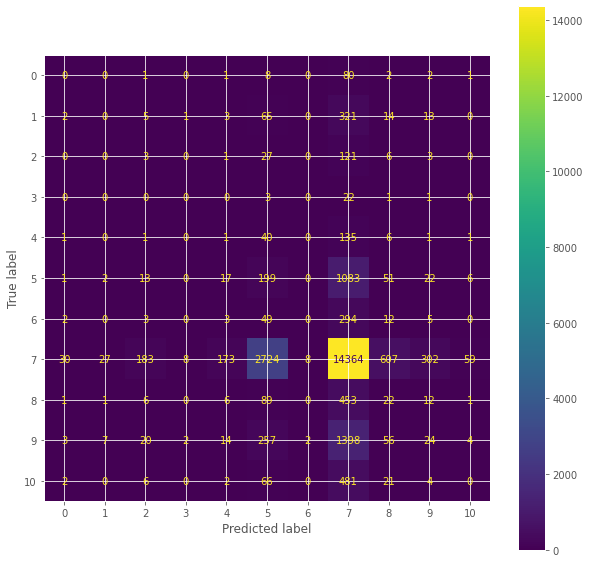

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(validation_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= list(range(11)))
disp.plot(ax=ax)